# UC Merced Land Use

In this example we are going to build a classifier with the dataset provided here: http://weegee.vision.ucmerced.edu/datasets/landuse.html

In [ ]:
# imports
import os 

import pandas as pd
import random 
import matplotlib.pyplot as plt
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from albumentations import Compose, Resize, VerticalFlip
import numpy as np
from tqdm import tqdm 

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

cuda:0


## Data exploration

Set the path to the dataset folder.

In [ ]:
PATH = 'data'

os.listdir(PATH)

['Images', 'readme.txt', 'readme.txt.bak']

In [ ]:
f = open(PATH + '/readme.txt', "r")
print(f.read())

UC Merced Land Use Dataset

October 28, 2010

This is a 21 class land use image dataset meant for research purposes.

There are 100 images for each class.

Each image measures 256x256 pixels.

The images were manually extracted from large images from the USGS National Map Urban Area Imagery collection for various urban areas around the country. The pixel resolution of this public domain imagery is 1 foot.

Please cite the following paper when publishing results that use this dataset:

Yi Yang and Shawn Newsam, "Bag-Of-Visual-Words and Spatial Extensions for Land-Use Classification," ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (ACM GIS), 2010.

Shawn D. Newsam
Assistant Professor and Founding Faculty
Electrical Engineering & Computer Science
School of Engineering
University of California, Merced
Voice: (209) 228-4167
Email: snewsam@ucmerced.edu
Web: http://faculty.ucmerced.edu/snewsam

This material is based upon work supported by the National S

Images are divided in different folders for each class

In [ ]:
labels = os.listdir(PATH+ '/Images')
labels, len(labels)

(['harbor',
  'denseresidential',
  'baseballdiamond',
  'chaparral',
  'golfcourse',
  'storagetanks',
  'parkinglot',
  'mobilehomepark',
  'buildings',
  'agricultural',
  'sparseresidential',
  'intersection',
  'overpass',
  'beach',
  'runway',
  'airplane',
  'forest',
  'river',
  'tenniscourt',
  'freeway',
  'mediumresidential'],
 21)

In [ ]:
for label in labels:
    items = os.listdir(PATH + '/Images/' + label)
    print(label, ':', len(items))

harbor : 100
denseresidential : 100
baseballdiamond : 100
chaparral : 100
golfcourse : 100
storagetanks : 100
parkinglot : 100
mobilehomepark : 100
buildings : 100
agricultural : 100
sparseresidential : 100
intersection : 100
overpass : 100
beach : 100
runway : 100
airplane : 100
forest : 100
river : 100
tenniscourt : 100
freeway : 100
mediumresidential : 100


Build dataframe with labels. For a classification problem where each image corresponds to one class only, labels are passed as integers. For multi-label problems, classes are passed as lists. The full name of the image relative to PATH is required to read the images correctly.

In [ ]:
img_name, cls = [], []
for i, label in enumerate(labels):
    names = os.listdir('{}/Images/{}'.format(PATH,label))
    img_name += ['{}/{}'.format(label,name) for name in names]
    cls += [i for name in names]
    
df = pd.DataFrame({'img': img_name, 'label': cls})
df.sample(5)

,img,label
1955,freeway/freeway31.tif,19
1590,airplane/airplane54.tif,15
916,agricultural/agricultural13.tif,9
1089,sparseresidential/sparseresidential13.tif,10
1373,beach/beach58.tif,13


In [ ]:
len(df)

2100

Visualize some images.

15 airplane
(256, 256, 3)


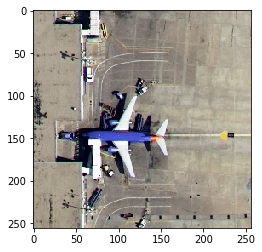

In [ ]:
ix = random.randint(0, len(df)-1)
img = io.imread('{}/Images/{}'.format(PATH, df.loc[ix].img))
plt.imshow(img)
cls = df.loc[ix].label
print(cls, labels[cls])
print(img.shape)

## Create the datasets

In order to train a model we need a train dataset and a validation dataset.

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, shuffle=True)
len(train_df), len(val_df)

(1680, 420)

In [ ]:
train_df.head()

,img,label
780,mobilehomepark/mobilehomepark94.tif,7
303,chaparral/chaparral17.tif,3
533,storagetanks/storagetanks63.tif,5
269,baseballdiamond/baseballdiamond38.tif,2
1532,airplane/airplane02.tif,15


We also can define transformations on the images.

In [ ]:
trans = Compose([
    Resize(224,224),
    VerticalFlip(p=0.5)
])

Now we can define our datasets. 

In [ ]:
from torch.utils.data import Dataset 

class ClassificationDataset(Dataset):
    """
    Dataset class for classification tasks
    """
    def __init__(self, path, imgs, labels=None, trans=None, train=True):
        self.path = path 
        self.imgs = imgs
        self.labels = labels
        self.trans = trans
        self.train = train
    
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, ix):
        img = io.imread('{}/{}'.format(self.path, self.imgs[ix]))  
        label = None     
        if self.train:
            label = self.labels[ix]
        if self.trans:
            augmented = self.trans(image=img)
            img = augmented['image'] 
        
        #return torch.from_numpy(img.transpose((2,0,1)).astype(np.float32)/255), label
        
        # return numpy array with image in uin8
        return img, label

In [ ]:
img_path, n_classes = '{}/Images'.format(PATH), len(labels)
dataset = {
    'train': ClassificationDataset(img_path, train_df.img.values, train_df.label.values, trans),
    'val': ClassificationDataset(img_path, val_df.img.values, val_df.label.values, trans)
}

The dataset will return the image and the label. We can visualize some images like this

(224, 224, 3) uint8
label:  18 tenniscourt


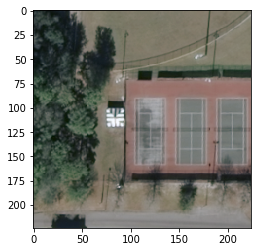

In [ ]:
idx = random.randint(0,len(dataset['train'])-1)
img, label = dataset['train'][idx]
print(img.shape, img.dtype)
#img = img.numpy().transpose((1,2,0))
plt.imshow(img)
print('label: ', label, labels[label])

## Build a model

For this problem we are going the load a pre-trained resnet34 and fine-tune it in our dataset.

In [ ]:
from typing import List

class Resnet(nn.Module):

    def __init__(self, labels):
        super(Resnet, self).__init__()
                
        # get pre-trained resnet34
        self.model = torchvision.models.resnet34(pretrained=True)
        
        # set new fc layer with our classes    
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, len(labels))

    # expect tensor with batch of images in uint8 and shape (width, height, channels)
    def forward(self, x):
        x = self.process(x)
        return self.model(x)
    
    # convert batch of images in uin8 to float, normalize and reshape
    def process(self, x):
        x = x.float()
        x = x / 255
        x = x.permute(0,3,1,2)
        return x
    
    # given a batch of images, return the index of the   
    # highest probability clas for each image
    def test(self, x):
        x = self.forward(x)
        x = torch.argmax(x, 1)  
        return x


In [ ]:
model = Resnet(labels)

# test model
test_image = np.random.randn(224,224,3) # resnet requires input size of 224x224 !
test_batch = np.stack([test_image for i in range(5)], axis=0)
input_batch = torch.from_numpy(test_batch)

output = model(input_batch)
output.shape

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:08<00:00, 10.9MB/s]


torch.Size([5, 21])

## Train the model

To train the model, first we need a dataloader to serve us images in batches.

In [ ]:
bs, nw = 32, 4
dataloader = {
    'train': DataLoader(dataset['train'], batch_size=bs, shuffle=True, num_workers=nw),
    'val': DataLoader(dataset['val'], batch_size=bs, shuffle=False, num_workers=nw)
}

Then we set the hyperparameters.

In [ ]:
# compute accuracy of model
def accuracy(preds, labels):
    preds = torch.argmax(preds, axis=1)
    total = labels.size(0)
    correct = (preds == labels).sum().item()
    return correct / total

In [ ]:
import torch.optim as optim
from deepcoral.utils import CosineWithRestarts

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
metric = accuracy
scheduler = None#CosineWithRestarts(optimizer, T_max=50, T_1=10)

And finally, we can start training.

In [ ]:
from deepcoral.classification.trainer import train_classifier as train

model.to(device)
# using default parameters
hist = train(model, dataloader, device, metric, criterion, optimizer, epochs=3, scheduler=scheduler, early_stop=60)

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 1/3
Training ...


  0%|          | 0/14 [00:00<?, ?it/s]

Evaluating ...


100%|##########| 14/14 [00:04<00:00,  3.41it/s]


Train Loss: 0.74780. Val Loss: 0.30045. Val acc: 0.89732
Best acc 0.8973214285714286, model saved


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 2/3
Training ...


  0%|          | 0/14 [00:00<?, ?it/s]

Evaluating ...


100%|##########| 14/14 [00:00<00:00, 26.63it/s]


Train Loss: 0.29285. Val Loss: 0.23939. Val acc: 0.91741
Best acc 0.9174107142857143, model saved


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 3/3
Training ...


  0%|          | 0/14 [00:00<?, ?it/s]

Evaluating ...


100%|##########| 14/14 [00:00<00:00, 26.01it/s]


Train Loss: 0.18985. Val Loss: 0.30987. Val acc: 0.91741
Best acc 0.9174107142857143


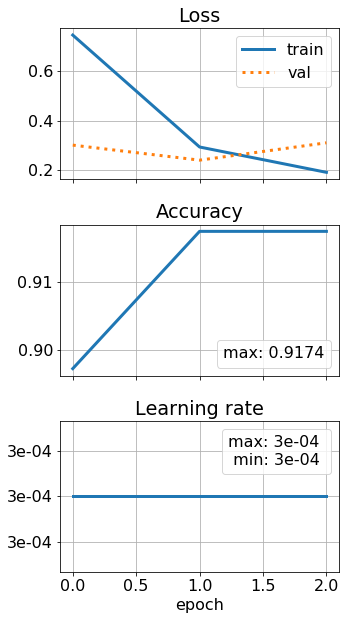

In [ ]:
from deepcoral.utils import plot_history as plot
plot(hist)

## Test the model

During the training phase, the model with the best accuracy according to the provided metric is saved. It can be used for inference or as an initial state for another training.

In [ ]:
model.load_state_dict(torch.load('state_dict.pth')['model_state_dict'])
#model = torch.jit.load('scripted_model.pth')

model.to(device)
model.eval();

Let's get some predictions and compare with the ground truth.


Ground truth:  10 sparseresidential
Prdiction:  tensor([10], device='cuda:0')


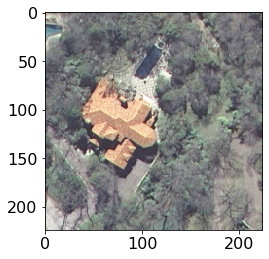

In [ ]:
idx = random.randint(0,len(dataset['val'])-1)
img, label = dataset['val'][idx]
preds = model.test(torch.from_numpy(np.array([img])).to(device)) 
plt.imshow(img)
print('\nGround truth: ', label, labels[label.item()])
print('Prdiction: ', preds)

Finally, we save the model for inference.

In [ ]:
inputs = {
    'forward': torch.rand(1, 224, 224, 3),
    'test': torch.rand(1, 224, 224, 3)
}

scripted_model = torch.jit.trace_module(model.cpu(), inputs)

torch.jit.save(scripted_model, 'scripted_model.pth')